In [1]:
import sys
sys.path.append('../FOLDER_2022_03_23_FOR_PAPER/')

import numpy as np
import matplotlib.pyplot as plt
import glob
import skimage


#image analysis
import sys
import os

import cv2

import pandas as pd
import skimage.io
import alienlab.plot
from alienlab.improcessing import normalize, grey_to_rgb, make_binary
import alienlab.segment
from alienlab.fo import FramesOperator
import alienlab.io
import glob
from alienlab.regression_func import *
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
import tqdm

import imageio
import itertools

from function_figures import *

p = alienlab.plot.ShowFigure()
p.extension = ".png"

p.date = False
p.figsize = (10,10)
p.fonttick=17
p.fontsize=25
p.save_folder = "G:/DREAM/from_github/Single_cell_paper/Figures/februaryy"





def init_image(file_path):
    frames_full = skimage.io.imread(file_path)

    #frames_full = np.stack([frames_full[:,:,1]]*10, 0) 
    #uncomment this line if you have a single RGB image. The [:,:,1] stands for selection of the green channel

    FO = FramesOperator(frames_full)
    im = normalize(FO.frames[0], 0, 1)
    im = grey_to_rgb(im)*255
    FO.compute_stats()

    # CROP
    #y, x = alienlab.io.select_roi(np.uint8(im)) #select area of interest

    FO.x = 100, 800
    FO.y = 100, 800
    #FO.crop() #crop image
    return FO


def segment_image(FO, contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast, interact = True, showit = False):
    
    start_time = time.time()
    FO.selected_inds = np.linspace(250, 2050, 91).astype(int)

    
    def make_mask(contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast, soft_hard_contrast, soft_hard_autolevel):
        #apply contrast filter to all frames
        frames_contrast = FO.apply(skimage.filters.rank.enhance_contrast,  selem = skimage.morphology.disk(contrast))
        #apply autolevel filter to all frames
        frames_autolevel = FO.apply(skimage.filters.rank.autolevel, selem = skimage.morphology.disk(autolevel))
        #sum the contrast images to get a reference grey-level contrast image
        frame_contrast = np.sum(frames_contrast, axis = 0)
        #sum the autolevel images to get a reference grey-level autolevel image
        frame_autolevel = np.sum(frames_autolevel, axis = 0)
        #obtain contrast mask from reference contrast image
        mask_contrast = make_binary(frame_contrast, soft_hard = soft_hard_contrast)
        #otbain autolevel mask from reference autolevel image
        mask_autolevel =  make_binary(frame_autolevel, soft_hard = soft_hard_autolevel)
        #intersection of contrast aud autolevel masks
        mask_intersect = mask_contrast * mask_autolevel
        #clean the masks with a binary opening
        mask_intersect = skimage.morphology.binary_opening(mask_intersect, selem = skimage.morphology.disk(disk_size))
        #mask_intersect = skimage.morphology.binary_erosion(mask_intersect, selem = skimage.morphology.disk(disk_size))

        #reference image of altitude for the watershed
        auto_contrast = normalize(mask_intersect * frame_autolevel)
        print("--- Computed binary mask in %04f seconds ---" % (time.time() - start_time))

        p.cmap = "inferno"
        if showit:
            p.figsize = (20,8)
            p.title_list =  'contrast', 'contrast threshold', 'mask intersect','autolevel', 'autolevel threshold','segmentation image'
            p.col_num = 3
            fig = p.multi([frame_contrast, mask_contrast, mask_intersect, 
                           frame_autolevel, mask_autolevel,  auto_contrast])
            p.save_name = 'Segmentation reference'
            p.saving(fig)
            
        return auto_contrast, mask_intersect
    auto_contrast, mask_intersect = make_mask(contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast, soft_hard_contrast = 1, soft_hard_autolevel = 1)
    ref, mask = make_mask(contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast, soft_hard_contrast = 0.3, soft_hard_autolevel = 0.5)

    start_time = time.time()

    #locate the local maxima
    local_maxi = alienlab.segment.local_maxima(auto_contrast, max_contrast, p,
                                                     ref_distance = dist_max, mask = mask_intersect, show = showit)
    #perform watershed segmentation
    watershed_im_mask = alienlab.segment.watershed(ref*mask_intersect, mask , local_maxi,
                                                         p, ref_distance = dist_seg, show = True)
    segmented = watershed_im_mask
    print("--- Computed segmentation in %04f seconds ---" % (time.time() - start_time))

    if showit:
        alienlab.segment.show_segmentation(FO, segmented, p)
        
    if interact == False:
       return watershed_im_mask, FO    

In [ ]:
list_y = []

for folder in glob.glob("*qE_calib*"):
    file = glob.glob(folder + "/video.tiff")[0]
    video = skimage.io.imread(file)
    mask = video[250]>40
    #plt.imshow(mask)
    y = np.mean(video.reshape(video.shape[0], -1)[:,mask.flatten()], axis = (1))
    list_y.append(y)
    plt.plot(y)

In [ ]:
for i, y in enumerate(list_y):
    label =  glob.glob("*qE_calib*")[i]
    if 'WT222' not in label:
        #plt.figure()
        plt.plot(y[y>10]/y[250], "k", label = label )
        #plt.legend()
plt.ylim(0, 1.5)

plt.xlabel("pulse")
plt.ylabel("FM")

In [ ]:
list_y = []
"""
for folder in glob.glob("*qE_calib*"):
    file = glob.glob(folder + "/video.tiff")[0]
    
    FO = init_image(file)
    p.save_folder= folder
    watershed_im_mask, FO    = segment_image(FO, contrast = 6, autolevel = 5, dist_max = True, dist_seg=True, disk_size = 1, max_contrast = 3, interact = False, showit= True)  
    np.save(folder + "/labels.npy", watershed_im_mask)
    
"""

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|███████████████████████████████████████████████████████████████████████████████| 405/405 [00:00<00:00, 733.68it/s]


-2.436193786049206 -0.17463178115319222 -2.5216869635391004 0.7568381774622294


100%|███████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 766.71it/s]


-2.144599614584593 -0.23283040595920262 -2.4070352684355325 1.0143673692225588


100%|███████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 776.78it/s]


-2.7006187522460863 -0.3384640260663892 -2.6602700387420732 0.8889121986649594


100%|███████████████████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 759.59it/s]


-2.1508016660020046 -0.09713447876142482 -2.0490733087351116 0.9553390685852984


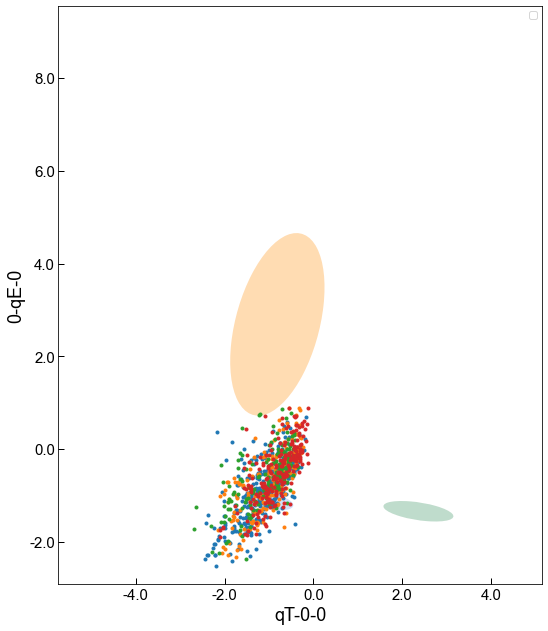

<Figure size 432x288 with 0 Axes>

In [22]:
list_pair2 = np.array([250, 270, 290, 1130, 1250, 1350, 1450, 1730, 2050])

couples = list(itertools.combinations(list_pair2, 2))

method = "combine4"


@delayed
@wrap_non_picklable_objects
def get_ratio_from_video(start_vid, F0, F1, mask_flat):
        video = imageio.get_reader(start_vid)
        frame_250 = video.get_data(250)
        frame_F0 = video.get_data(F0)
        frame_F1 = video.get_data(F1)
        r0  = (frame_250 - frame_F0)/frame_F0
        r1 = (frame_250 - frame_F1)/frame_F1
        diff = r1-r0
        diff = np.nan_to_num(diff, neginf=0, nan=0, posinf=0) 
        return diff.flatten()[mask_flat!=0]
    
def transform_data(data, transform):
    #print(data.shape, transform.shape)
    #data = (data - M_lda.T)/S_lda.T
    XT = np.dot(data, transform.T)
    return XT

x, y = 0,1

fig1, ax1 = create_ellipse(method, [purple, orange, green], x, y, id_list, Z, lims)


for folder in glob.glob("../FOLDER_2022_12_14_SP_check/*qE_calib*"):
    
    if "WT4_qE_calib_1" in folder:

        labels = glob.glob(folder + "/labels.npy")[0]

        mask = np.load(labels)

        mask_flat = mask.flatten()

        transforms = []

        diffs = []


        video = glob.glob(folder + "/video.tiff")[0]

        diff = Parallel(n_jobs = -1 )(get_ratio_from_video(video, couple[0], couple[1], mask_flat) for couple in tqdm.tqdm(couples))
        diff = np.array(diff)
        diffs.append(diff)
        diffs = np.array(diffs)

        diff_labels = []
        for label in tqdm.tqdm(np.unique(mask)):
            s = np.sum(mask==label)
            if label !=0 and s>5:# and s<60:
                diff_labels.append(np.mean(diffs[:,:,mask_flat[mask_flat!=0]==label], axis = -1))

        diff_labels = np.array(diff_labels)
        diff_labels.shape


        RTr = pd.read_csv("../FOLDER_2022_03_23_FOR_PAPER/plotly_data/combine4_array_RTr.csv", sep = " ", header = None)
        M_lda = np.array(pd.read_csv("../FOLDER_2022_03_23_FOR_PAPER/plotly_data/combine4_array_M_lda.csv",  sep = " ", header = None))
        S_lda = np.array(pd.read_csv("../FOLDER_2022_03_23_FOR_PAPER/plotly_data/combine4_array_S_lda.csv",  sep = " ", header = None))




        compare  = []
        for j, i in enumerate(range(0,1)):
            arr = diff_labels[:,i,:]
            #u = transform_data((arr-M_lda.T)/S_lda.T, RTr)
            u = transform_data(arr, RTr)

            #u = transform_data(arr, RTr)
            Xc, Yc =  u[:,0], u[:,1]
            Xc, Yc = clip_xy(u[:,x], u[:,y])
            ax1.plot(Xc, Yc, ".", label = os.path.split(folder)[1])#, color = ["darkorange","goldenrod"][j], alpha = 0.5)
            compare.append(u)
#plt.legend()

p.save_name = 'SP_effect/compare_points_%s_%d'%("SP", 1)
u = p.saving(fig1)
